In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/wandb/RAGTruth-processed/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15090 entries, 0 to 15089
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15090 non-null  object 
 1   query                           15090 non-null  object 
 2   context                         15090 non-null  object 
 3   output                          15090 non-null  object 
 4   task_type                       15090 non-null  object 
 5   quality                         15090 non-null  object 
 6   model                           15090 non-null  object 
 7   temperature                     15090 non-null  float32
 8   hallucination_labels            15090 non-null  object 
 9   hallucination_labels_processed  15090 non-null  object 
 10  input_str                       15090 non-null  object 
dtypes: float32(1), object(10)
memory usage: 1.2+ MB


In [ ]:
df["task_type"].unique()

array(['Summary', 'Data2txt', 'QA'], dtype=object)

In [ ]:
df = df[df['quality'] == 'good']

In [ ]:
def extract_binary_label(hallucination_labels):
    return 1 if any(value == 1 for value in hallucination_labels.values()) else 0


df['binary_label'] = df['hallucination_labels_processed'].apply(extract_binary_label)

# Step 2.2: Multi-class label creation
def extract_multiclass_label(labels):
    """
    Converts the hallucination_labels dictionary into a multi-class label.
    """
    if labels['evident_conflict'] == 1 and labels['baseless_info'] == 1:
        return 3  # Both types
    elif labels['evident_conflict'] == 1:
        return 1  # Evident conflict only
    elif labels['baseless_info'] == 1:
        return 2  # Baseless info only
    else:
        return 0  # No hallucination

df['multiclass_label'] = df['hallucination_labels_processed'].apply(extract_multiclass_label)

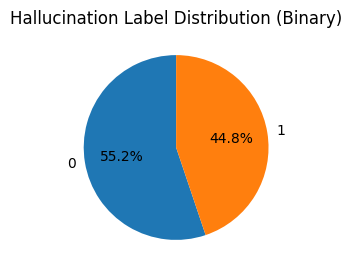

In [ ]:
import matplotlib.pyplot as plt

label_counts = df['binary_label'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Hallucination Label Distribution (Binary)")
plt.show()


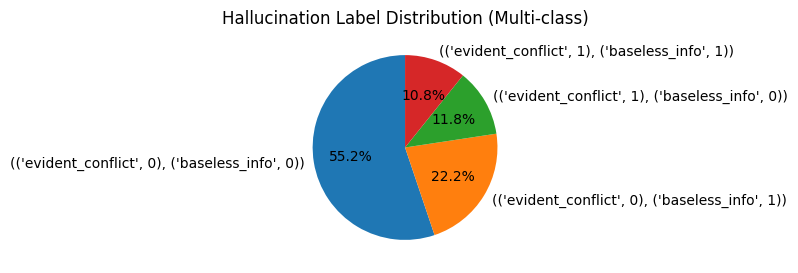

In [ ]:
label_counts = df['hallucination_labels_processed'].apply(lambda x: tuple(x.items())).value_counts()

plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=[str(label) for label in label_counts.index], autopct='%1.1f%%', startangle=90)
plt.title("Hallucination Label Distribution (Multi-class)")
plt.show()

In [ ]:
def tokenize_function(row, tokenizer, max_length=512):
    query_max_len = max_length // 4
    context_max_len = max_length // 2
    output_max_len = max_length // 4

    query_text = f"QUERY: {row['query']} "
    context_text = f"CONTEXT: {row['context']} "
    output_text = f"OUTPUT: {row['output']} "

    query_tokens = tokenizer(query_text, truncation=True, padding='max_length', max_length=query_max_len, return_tensors="pt")
    context_tokens = tokenizer(context_text, truncation=True, padding='max_length', max_length=context_max_len, return_tensors="pt")
    output_tokens = tokenizer(output_text, truncation=True, padding='max_length', max_length=output_max_len, return_tensors="pt")

    combined_input_ids = torch.cat([
        query_tokens['input_ids'][0],
        context_tokens['input_ids'][0],
        output_tokens['input_ids'][0]
    ]).unsqueeze(0)

    combined_attention_mask = torch.cat([
        query_tokens['attention_mask'][0],
        context_tokens['attention_mask'][0],
        output_tokens['attention_mask'][0]
    ]).unsqueeze(0)

    return {"input_ids": combined_input_ids, "attention_mask": combined_attention_mask}


In [ ]:
from transformers import AutoTokenizer
import torch

def collate_fn(batch):

    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    input_ids = []
    attention_masks = []
    binary_labels = []


    for example in batch:
        input_ids.append(example['input_ids'].squeeze(0))
        attention_masks.append(example['attention_mask'].squeeze(0))
        binary_labels.append(example['binary_label'])

    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'binary_label':  torch.tensor(binary_labels, dtype=torch.float)
    }


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tokens = tokenize_function(row, self.tokenizer, self.max_length)
        labels = {
            "binary_label": torch.tensor(row['binary_label'], dtype=torch.float),
        }
        return {**tokens, **labels}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_bin = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_dataset = CustomDataset(train_data, tokenizer, max_length=512)
val_dataset = CustomDataset(val_data, tokenizer, max_length=512)
test_dataset = CustomDataset(test_data, tokenizer, max_length=512)

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

def train_and_evaluate(model, train_dataset, val_dataset, tokenizer, epochs, batch_size, device):
    optimizer = torch.optim.AdamW(model.parameters(),  lr=2e-5)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

    model.to(device)

    for epoch in range(epochs):
        # Training loop
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['binary_label'].float().to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)
            loss = F.binary_cross_entropy_with_logits(logits, labels)

            total_train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        total_eval_loss = 0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Evaluating Epoch {epoch + 1}/{epochs}"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['binary_label'].float().to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits.squeeze(-1)
                loss = F.binary_cross_entropy_with_logits(logits, labels)

                total_eval_loss += loss.item()

                # Compute predictions
                probabilities = torch.sigmoid(logits)
                predictions = (probabilities >= 0.5).long()

                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_eval_loss = total_eval_loss / len(val_dataloader)
        avg_eval_accuracy = total_correct / total_samples

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_eval_loss:.4f}")
        print(f"Validation Accuracy: {avg_eval_accuracy * 100:.2f}%")




In [ ]:
epochs = 5
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

train_and_evaluate(model_bin, train_dataset, val_dataset, tokenizer, epochs, batch_size, device)

Evaluating Epoch 1/5: 100%|██████████| 43/43 [00:50<00:00,  1.16s/it]


Epoch 1/5
Train Loss: 0.5771
Validation Loss: 0.5425
Validation Accuracy: 73.46%


Evaluating Epoch 2/5: 100%|██████████| 43/43 [00:51<00:00,  1.19s/it]


Epoch 2/5
Train Loss: 0.5283
Validation Loss: 0.5314
Validation Accuracy: 73.38%


Evaluating Epoch 3/5: 100%|██████████| 43/43 [00:50<00:00,  1.18s/it]


Epoch 3/5
Train Loss: 0.4831
Validation Loss: 0.5402
Validation Accuracy: 73.75%


Evaluating Epoch 4/5: 100%|██████████| 43/43 [00:50<00:00,  1.19s/it]


Epoch 4/5
Train Loss: 0.4163
Validation Loss: 0.5808
Validation Accuracy: 74.35%


Evaluating Epoch 5/5: 100%|██████████| 43/43 [00:50<00:00,  1.18s/it]

Epoch 5/5
Train Loss: 0.3254
Validation Loss: 0.6257
Validation Accuracy: 74.05%


In [ ]:
torch.save(model_bin.state_dict(), "/content/drive/MyDrive/hallucination/model_bert_5_epochs.pth")